### 循环神经网络模型模型：Encoder-Decoder with LSTM cell

先按EmergingScore总量将术语进行分组，然后为各组训练单独的模型，将预测结果拼合

0.736 gene MAE

0.721 transplant MAE

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/es_with_decay.array'
transplant_arr_path = r'../output/transplant/es_with_decay.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 10)
Shape of the transplant array: (5141, 17, 10)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [3]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 10)
Shape of the transplant array: (5141, 16, 10)


### Extra：按照前N年的Emerging Score的总量进行区分

要先划分训练集和测试集，然后才能够和其他模型横评

共训练四个模型，将其预测结果合并

In [4]:
def split_data_by_es(data, targets):
    total_es = np.sum(data[:, :11, -2], axis=1)
    q75, q25 = np.percentile(total_es, [75 ,25])
    iqr = q75 - q25
    upper_bond = q75 + 1.5 * iqr
    lower_bond = q25 - 1.5 * iqr
    
    data1, target1 = data[np.argwhere(total_es > upper_bond).reshape(-1)], targets[np.argwhere(total_es > upper_bond).reshape(-1)]
    data2, target2 = data[np.argwhere((q75 < total_es) & (total_es <= upper_bond)).reshape(-1)], targets[np.argwhere((q75 < total_es) & (total_es <= upper_bond)).reshape(-1)]
    data3, target3 = data[np.argwhere((q25 < total_es) & (total_es <= q75)).reshape(-1)], targets[np.argwhere((q25 < total_es) & (total_es <= q75)).reshape(-1)]
    data4, target4 = data[np.argwhere(total_es <= q25).reshape(-1)], targets[np.argwhere(total_es <= q25).reshape(-1)]
    
    return data1, target1, data2, target2, data3, target3, data4, target4

In [20]:
# scaler, data = scale_data(gene_arr, 'standard')
scaler, data = scale_data(transplant_arr, 'standard')
X_train, X_test, y_train, y_test = split_data(data, n_input=11, ratio=0.2)

X_train1, y_train1, X_train2, y_train2, X_train3, y_train3, X_train4, y_train4 = split_data_by_es(X_train, y_train)
X_test1, y_test1, X_test2, y_test2, X_test3, y_test3, X_test4, y_test4 = split_data_by_es(X_test, y_test)

print('X_trains shape：', X_train1.shape, X_train2.shape, X_train3.shape, X_train4.shape)
print('Y_trains shape：', y_train1.shape, y_train2.shape, y_train3.shape, y_train4.shape)
print()
print('X_tests shape：', X_test1.shape, X_test2.shape, X_test3.shape, X_test4.shape)
print('Y_tests shape：', y_test1.shape, y_test2.shape, y_test3.shape, y_test4.shape)

X_trains shape： (293, 11, 10) (735, 11, 10) (2055, 11, 10) (1029, 11, 10)
Y_trains shape： (293, 5) (735, 5) (2055, 5) (1029, 5)

X_tests shape： (82, 11, 10) (175, 11, 10) (514, 11, 10) (258, 11, 10)
Y_tests shape： (82, 5) (175, 5) (514, 5) (258, 5)


### 检查各组内的特征相似性

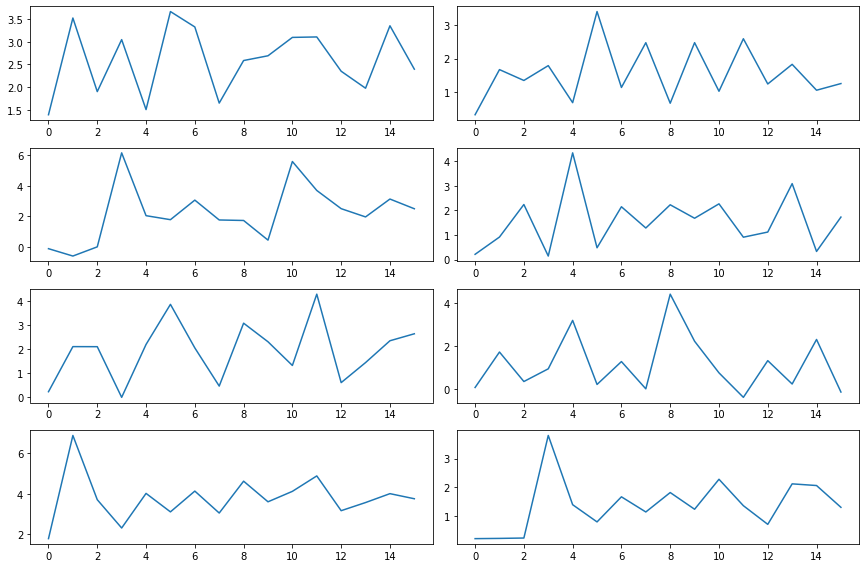

In [6]:
plot_datax, plot_datay = X_train1, y_train1
ids = random.sample(range(len(plot_datax)), 10)

plt.figure(figsize=(12,8))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(np.arange(16), np.concatenate((plot_datax[ids[i], :, -2], plot_datay[ids[i]])))
plt.tight_layout()
plt.show()

### 构建模型

In [7]:
def build_encoder_decoder_model(lstm_units, dense_units, lr):
    model = keras.models.Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(dense_units, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    optimizer=keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mae', optimizer=optimizer)
    return model

训练

In [21]:
train_xs = [X_train1, X_train2, X_train3, X_train4]
train_ys = [y_train1, y_train2, y_train3, y_train4]
test_xs = [X_test1, X_test2, X_test3, X_test4]
test_ys = [y_test1, y_test2, y_test3, y_test4]
i_s = [1, 2, 3, 4]

In [ ]:


for train_x, train_y, test_x, test_y, i in zip(train_xs, train_ys, test_xs, test_ys, i_s):
    model = build_encoder_decoder_model(256, 256, 0.0001)
    history = model.fit(train_x, train_y, epochs=100, batch_size=16, verbose=1, validation_data=(test_x, test_y), 
                   callbacks=[
                       ModelCheckpoint('rnn_model{}_checkpoint.h5'.format(i), save_best_only=True,verbose=1)
                   ])


预测

In [22]:
models = []
for i in range(1, 5):
    models.append(keras.models.load_model('trained_models/transplant_rnn/rnn_model{}_checkpoint.h5'.format(i)))

In [37]:
X_tests = []
X_trains = []
train_preds = []
y_preds = []
y_tests = []
y_trains = []
for i in range(len(models)):
    X_trains.append(train_xs[i])
    train_preds.append(models[i].predict(train_xs[i]).reshape(train_ys[i].shape))
    y_trains.append(train_ys[i])
    X_tests.append(test_xs[i])
    y_preds.append(models[i].predict(test_xs[i]).reshape(test_ys[i].shape))
    y_tests.append(test_ys[i])
y_pred = np.concatenate(y_preds)
y_test = np.concatenate(y_tests)
X_test = np.concatenate(X_tests)
X_train = np.concatenate(X_trains)
y_train = np.concatenate(y_trains)
train_pred = np.concatenate(train_preds)

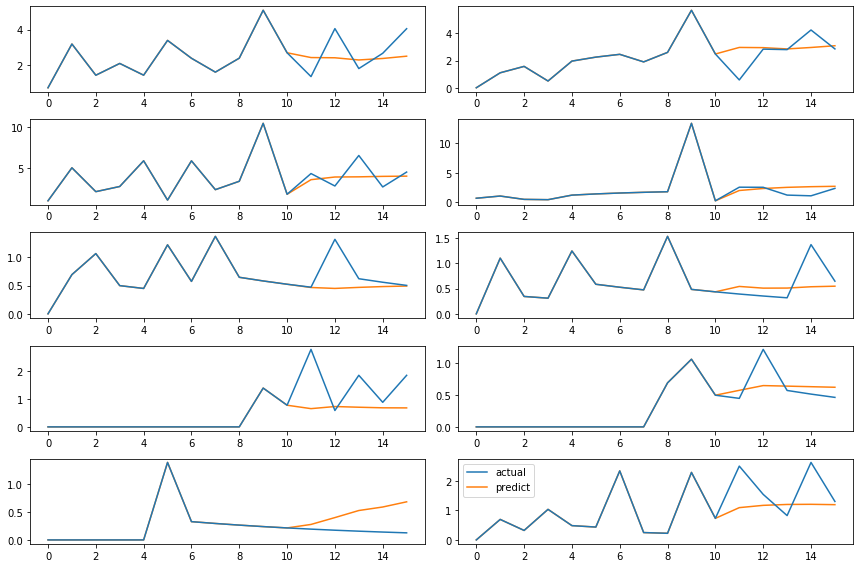

In [34]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_test[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_test[ids[i]].reshape(-1), axis=0))), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_test[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_pred[ids[i]].reshape(-1), axis=0))), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

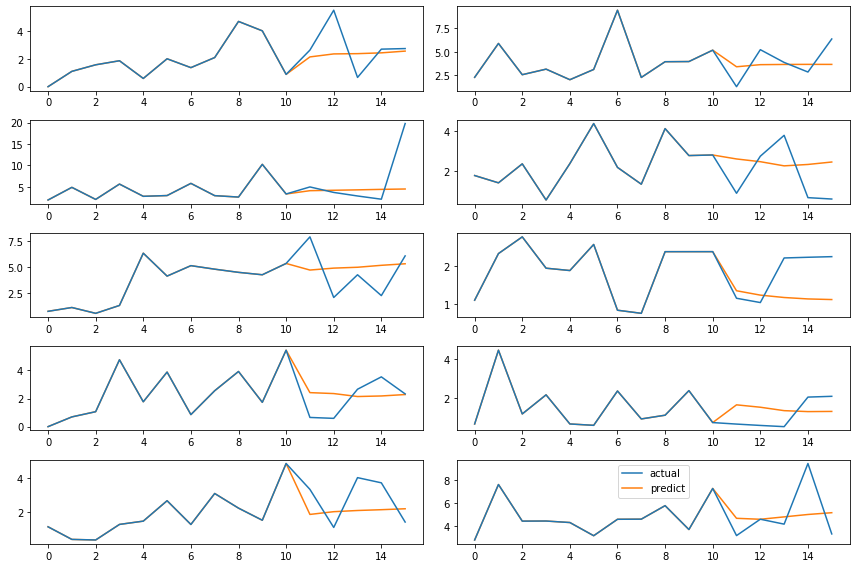

In [46]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_train[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(y_train[ids[i]].reshape(-1), axis=0))), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((scaler.inverse_transform(np.expand_dims(X_train[ids[i], :, -2], axis=0)), scaler.inverse_transform(np.expand_dims(train_pred[ids[i]].reshape(-1), axis=0))), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

MAE: 0.7364369393834682
MAE: [0.39732348 0.59654395 0.76806346 0.87884174 1.04141208]


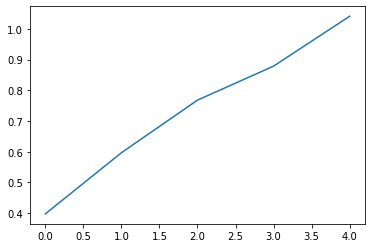

NDCG: 0.3267858573041519
NDCG: [0.3757003011612274, 0.49425446745759805, 0.01792937844267833, 0.023038939706123106, 0.012534688038283694]


C:\Users\Tom Leung\OneDrive\文件\武汉大学\硕士投稿\主题热度预测\program\utils.py:36: RuntimeWarning: invalid value encountered in true_divide
  pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))


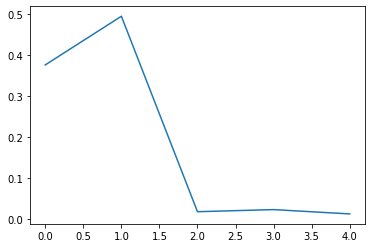

RMSE: 1.4402419045997055
RMSE: [1.02386657 1.04221067 1.55386802 1.60324384 1.80335279]


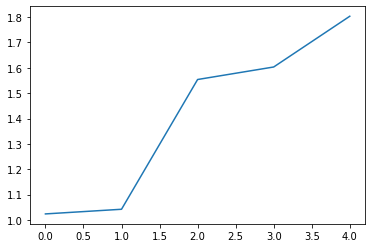

MAPE: 4.047815137910925
MAPE: [1.94858061 2.27790981 2.70620922 4.9074776  8.39889845]


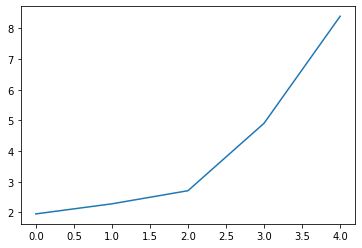

In [9]:
metrics = ['mae', 'ndcg','rmse','mape']

for m in metrics:
    overall, annual = eval_model(m, y_test, y_pred.reshape(len(y_test), -1), scaler)
    print('{}:'.format(m.upper()), overall)
    print('{}:'.format(m.upper()),annual)
    plt.plot(annual)
    plt.show()

In [34]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59        27
         1.0       0.69      0.67      0.68      3248
         2.0       0.18      0.18      0.18      1059
         3.0       0.40      0.34      0.37       548
         4.0       0.21      0.28      0.24       263

    accuracy                           0.52      5145
   macro avg       0.38      0.50      0.41      5145
weighted avg       0.53      0.52      0.52      5145

